# Example notebook: Emission constraint

In this notebook we demonstrate how the emission constraint impact results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler

from tno.quantum.problems.portfolio_optimization import (
    PortfolioOptimizer,
    plot_front,
    plot_points,
)

## Define basic portfolio optimization problem

In [2]:
# Choose QUBO sampler
sampler = SimulatedAnnealingSampler()
sampler_kwargs = {"num_reads": 20, "num_sweeps": 200}

# Set up penalty coefficients for the constraints
lambdas1 = np.logspace(-16, 1, 25, endpoint=False, base=10.0)
lambdas2 = np.logspace(-16, 1, 25, endpoint=False, base=10.0)
lambdas3 = np.array([1])

In [3]:
# Define basic portfolio optimization problem instance
portfolio_optimizer = PortfolioOptimizer(portfolio_data="benchmark_dataset", k=2)
portfolio_optimizer.add_minimize_hhi(weights=lambdas1)
portfolio_optimizer.add_maximize_roc(formulation=1, weights_roc=lambdas2)

### Solve without emission constraint

In [4]:
# Solve the portfolio optimization problem without emission constraint
results_no_constraint = portfolio_optimizer.run(sampler, sampler_kwargs)

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:11<00:00, 55.25it/s]


Drop duplicate samples in results.
Number of unique samples:  18
Time consumed: 0:00:11.366228


### Solve with emission constraint

In [5]:
# Add the emission constrained
portfolio_optimizer.add_emission_constraint(
    weights=lambdas3,
    emission_now="emis_intens_now",
    emission_future="emis_intens_future",
    name="emission",
)

In [6]:
# Solve the constrained portfolio optimization problem
results_emission_constraint = portfolio_optimizer.run(sampler, sampler_kwargs)

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:25<00:00, 24.87it/s]


Drop duplicate samples in results.
Number of unique samples:  12500
Time consumed: 0:00:25.167966


## Visualize results

In [7]:
# Results unconstrained problem
results_df1 = results_no_constraint.results_df
x1, y1 = results_df1["diff diversification"], results_df1["diff ROC"]

In [8]:
# Compute "diff emission" column manually
portfolio_data = results_no_constraint.portfolio_data
outstanding_now = portfolio_data.get_outstanding_now()
total_outstanding_now = np.sum(outstanding_now)
emission_intensity_now = portfolio_data.get_column("emis_intens_now")
emission_intensity_future = portfolio_data.get_column("emis_intens_future")

def calculate_diff_emission(outstanding_future):
    """Calculate manually "diff emission" values"""
    total_outstanding_future = np.sum(outstanding_future)
    total_relative_emission_now = (
        np.sum(outstanding_now * emission_intensity_now) / total_outstanding_now
    )
    total_relative_emission_future = (
        np.sum(outstanding_future * emission_intensity_future)
        / total_outstanding_future
    )
    return 100 * (total_relative_emission_future / total_relative_emission_now - 1)


results_df1["diff emission"] = results_df1["outstanding amount"].apply(
    calculate_diff_emission
)
results_df1.head()

,outstanding amount,diff ROC,diff diversification,diff outstanding,diff emission
0,"(14.0, 473.0, 24.0, 1090.0, 56.0, 291.0, 12.0,...",2.709585,-2.496949,1.292965,-24.851818
4,"(14.0, 473.0, 24.0, 1090.0, 56.0, 291.0, 12.0,...",2.769648,-2.494465,1.292981,-24.852575
20,"(14.0, 473.0, 24.0, 1090.0, 56.0, 291.0, 12.0,...",3.247117,-2.474602,1.293106,-24.859097
100,"(14.0, 473.0, 24.0, 1090.0, 56.0, 291.0, 12.0,...",3.380810,-2.437864,1.293342,-24.870455
120,"(19.0, 473.0, 24.0, 1090.0, 56.0, 291.0, 12.0,...",2.548857,-2.320262,1.294094,-24.894073


In [9]:
# Results constrained problem
results_df2 = results_emission_constraint.results_df
x2, y2 = results_df2["diff diversification"], results_df2["diff ROC"]
results_df2.head()

,outstanding amount,diff ROC,diff diversification,diff outstanding,diff emission
0,"(17.333333333333332, 491.3333333333333, 26.666...",2.851864,-1.998665,1.510208,-29.999906
1,"(14.0, 491.3333333333333, 28.0, 1410.0, 62.0, ...",1.739756,-1.834305,1.504201,-30.000001
2,"(15.666666666666666, 528.0, 28.0, 1410.0, 68.0...",2.802582,-3.463787,1.518929,-30.000131
3,"(15.666666666666666, 528.0, 28.0, 1410.0, 62.0...",3.001493,-6.190747,1.555238,-29.999856
4,"(19.0, 491.3333333333333, 28.0, 1410.0, 56.0, ...",1.036203,-0.978489,1.499527,-29.999957


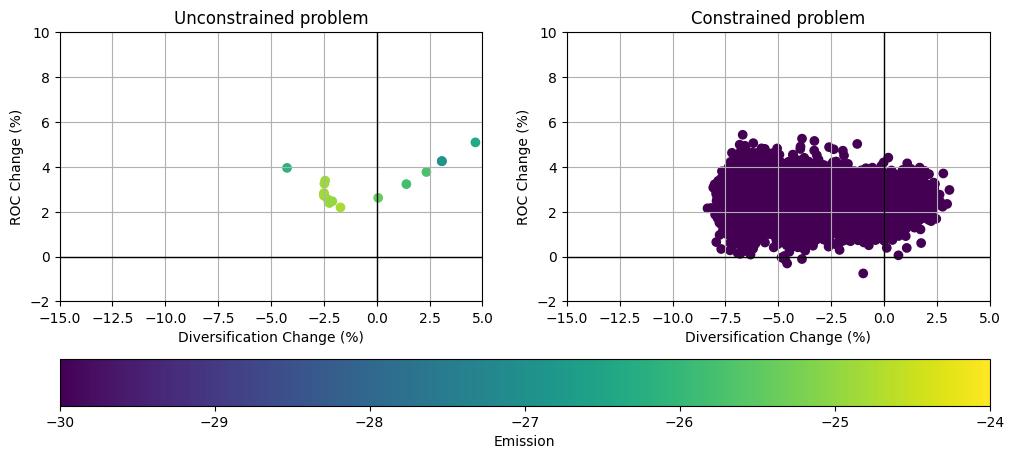

In [10]:
# Plot results
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
(ax1, ax2) = axs
scatter1 = plot_points(
    x1, y1, ax=ax1, c=results_df1["diff emission"], cmap="viridis", vmin=-30, vmax=-24
)
scatter2 = plot_points(
    x2, y2, ax=ax2, c=results_df2["diff emission"], cmap="viridis", vmin=-30, vmax=-24
)

ax1.set_title("Unconstrained problem")
ax2.set_title("Constrained problem")
cbar = fig.colorbar(scatter2, ax=axs, orientation="horizontal", label="Emission")

for ax in axs:
    ax.set_xlim(-15, 5)
    ax.set_ylim(-2, 10)